<a href="https://colab.research.google.com/github/ThisDavidAdams/MMR-summarization/blob/main/MMR_Summarisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Clone WCEP Repository and install dependencies


In [1]:
!git clone https://github.com/complementizer/wcep-mds-dataset
%cd wcep-mds-dataset

Cloning into 'wcep-mds-dataset'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 121 (delta 62), reused 91 (delta 37), pack-reused 0
Receiving objects: 100% (121/121), 1.09 MiB | 1.10 MiB/s, done.
Resolving deltas: 100% (62/62), done.
/content/wcep-mds-dataset


In [2]:
!pip install -r experiments/requirements.txt
!python -m nltk.downloader punkt

     |████████████████████████████████| 6.8MB 2.1MB/s 
     |████████████████████████████████| 1.6MB 64.9MB/s 
     |████████████████████████████████| 1.4MB 38.8MB/s 
  Cloning git://github.com/clic-lab/newsroom.git to /tmp/pip-install-dz8n9ga2/newsroom
  Running command git clone -q git://github.com/clic-lab/newsroom.git /tmp/pip-install-dz8n9ga2/newsroom
     |████████████████████████████████| 61kB 9.4MB/s 
     |████████████████████████████████| 184kB 58.6MB/s 
  Created wheel for nltk: filename=nltk-3.5-cp37-none-any.whl size=1434691 sha256=b6f554f685c3b59698bf6ad8830c82514ee4ddd29db8d4a499039ee4f9ab3869
  Stored in directory: /root/.cache/pip/wheels/ae/8c/3f/b1fe0ba04555b08b57ab52ab7f86023639a526d8bc8d384306
  Created wheel for newsroom: filename=newsroom-0.1-cp37-none-any.whl size=281701 sha256=c62ee3a23d1989f58045abe85f39abfd4b70c19c3dc93440df9cb286d8de4b13
  Stored in directory: /tmp/pip-ephem-wheel-cache-k7lg8wuz/wheels/d5/c4/c7/23cd619d0c4202ef81a4509bfbaa6d90d89200c3ee15e518

## Download the test dataset

WCEP-100

In [3]:
!mkdir WCEP
!gdown https://drive.google.com/uc?id=1qsd5pOCpeSXsaqNobXCrcAzhcjtG1wA1 -O WCEP/test.jsonl.gz

Downloading...
From: https://drive.google.com/uc?id=1qsd5pOCpeSXsaqNobXCrcAzhcjtG1wA1
To: /content/wcep-mds-dataset/WCEP/test.jsonl.gz
51.5MB [00:00, 53.4MB/s]


In [4]:
import experiments.utils as utils

test_data = list(utils.read_jsonl_gz('WCEP/test.jsonl.gz'))
partial_test_data = test_data[:50] # for experimenting
print("Number of clusters:",len(test_data))
print(test_data[0].keys())

Number of clusters: 1022
dict_keys(['id', 'date', 'reference_urls', 'articles', 'summary', 'wiki_links', 'category'])


In [5]:
# summary_max = 0
# article_max = 0
# for c in test_data:
#   summary_max = max(summary_max,len(c['summary'].split(" ")))

#   for a in c['articles']:
#     if article_max < len(a['text'].split(" ")):
#       text = a["text"]
#     article_max = max(article_max,len(a['text'].split(" ")))

In [6]:
from statistics import mean

article_word_count = [len(a['text'].split()) for c in test_data for a in c["articles"]]
summary_word_count = [len(c['summary'].split()) for c in test_data]

print("max word count of articles:",max(article_word_count))
print("max word count of summary:",max(summary_word_count))
print("avg word count of articles:", int(mean(article_word_count)))
print("avg word count of summary:", int(mean(summary_word_count)))

max word count of articles: 13736
max word count of summary: 119
avg word count of articles: 403
avg word count of summary: 31


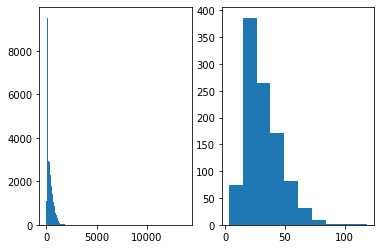

In [7]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)  
plt.hist(article_word_count, bins = 500)
plt.subplot(1, 2, 2)  
plt.hist(summary_word_count)
plt.show()

In [8]:
max_summary_length = 60
min_summary_length = 20

## Importing the pretrained models

In [9]:
!pip install torch
!pip install transformers
!pip install sentencepiece
!pip install spacy
!pip install bert-extractive-summarizer

     |████████████████████████████████| 2.3MB 2.9MB/s 
     |████████████████████████████████| 901kB 21.3MB/s 
     |████████████████████████████████| 3.3MB 21.5MB/s 
     |████████████████████████████████| 1.2MB 2.8MB/s 


In [10]:
!python -m spacy download en_core_web_md

     |████████████████████████████████| 96.4MB 104.1MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-cp37-none-any.whl size=98051304 sha256=b6539e3dffa70df3a60c905069d4d6584efb3d9daba133137d646437109bed87
  Stored in directory: /tmp/pip-ephem-wheel-cache-0x43o74l/wheels/df/94/ad/f5cf59224cea6b5686ac4fd1ad19c8a07bc026e13c36502d81
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [11]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [12]:
import warnings
warnings.filterwarnings("ignore")

In [13]:
# PEGASUS

from transformers import PegasusForConditionalGeneration, PegasusTokenizer

class Pegasus():

  def __init__(self,device):
    self.name = "Pegasus"
    self.model_name = "google/pegasus-xsum"
    self.tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-xsum")
    self.device = device
    self.model = PegasusForConditionalGeneration.from_pretrained("google/pegasus-xsum").to(device)
  
  def summarise(self, text):
    inputs = self.tokenizer([text], max_length=512, truncation = True, return_tensors='pt')
    inputs.to(self.device)
    translated = self.model.generate(inputs['input_ids'],
                                        num_beams=4,
                                        no_repeat_ngram_size=2,
                                        min_length=min_summary_length,
                                        max_length=max_summary_length)
    summary = self.tokenizer.batch_decode(translated, skip_special_tokens=True)

    return summary[0]



In [14]:
# T5

from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config

class T5():
  
  def __init__(self,device):
    self.name = "T5"
    self.device = device
    self.model = T5ForConditionalGeneration.from_pretrained('t5-large').to(device)
    self.tokenizer = T5Tokenizer.from_pretrained('t5-large')

  def summarise(self, text):
    text = "summarize: " + text
    tokenized_text = self.tokenizer.encode(text, return_tensors="pt", truncation = True).to(self.device)

    summary_ids = self.model.generate(tokenized_text,
                                        no_repeat_ngram_size=2,
                                        min_length=min_summary_length,
                                        max_length=max_summary_length,
                                        num_beams=5,
                                        temperature=0.7,
                                        early_stopping=True,
                                        top_p = 0.9
                                      )
    
    summary = self.tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    return summary


In [15]:
# GPT2

from transformers import GPT2Tokenizer, GPT2LMHeadModel

class GPT2():

  def __init__(self,device):
    self.name = "GPT2"
    self.device = device
    self.model = GPT2LMHeadModel.from_pretrained("gpt2").to(self.device)
    self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

  def summarise(self,text):
    input_ids = self.tokenizer.encode(text, return_tensors = 'pt', truncation=True, max_length = 961)
    tldr = self.tokenizer.encode(" TL;DR:", return_tensors = 'pt')
    input_ids = torch.cat((input_ids,tldr),-1)
    input_ids = input_ids.to(self.device)
    beam_output = self.model.generate(input_ids, 
                                      min_length = len(input_ids[0]) + min_summary_length,
                                      max_length=len(input_ids[0]) + max_summary_length, 
                                      num_beams=5,
                                      no_repeat_ngram_size=2, 
                                      temperature=0.5,
                                      early_stopping=True,
                                      top_p = 0.9
                                    )
    output = self.tokenizer.decode(beam_output[0], skip_special_tokens=True)
    
    summary = output.split("TL;DR:")[-1]
    return summary

In [16]:
# XLNet

from transformers import XLNetTokenizer, XLNetLMHeadModel

class XLNet():
  
  def __init__(self,device):
    self.name = "XLNet"
    self.device = device
    self.tokenizer = XLNetTokenizer.from_pretrained('xlnet-large-cased')
    self.model = XLNetLMHeadModel.from_pretrained('xlnet-large-cased').to(device)

  def summarise(self,text):
    input_ids = self.tokenizer.encode(text, return_tensors = 'pt', truncation=True, max_length = 961)
    tldr = self.tokenizer.encode(" TL;DR:", return_tensors = 'pt')
    input_ids = torch.cat((input_ids,tldr),-1)
    input_ids = input_ids.to(self.device)
    beam_output = self.model.generate(input_ids,
                                min_length=len(input_ids[0]) + min_summary_length,
                                max_length=len(input_ids[0]) + max_summary_length, 
                                num_beams=5,
                                no_repeat_ngram_size=2, 
                                temperature=0.7,
                                early_stopping=True,
                                top_p = 0.9
                                )
    
    output = self.tokenizer.decode(beam_output[0], skip_special_tokens=True)
    output = output.split("TL;DR:")[-1]
    return output
  

In [17]:
# ProphetNet

from transformers import ProphetNetTokenizer, ProphetNetForConditionalGeneration

class ProphetNet():

  def __init__(self,device):
    self.name = "ProphetNet"
    self.device = device
    self.tokenizer = ProphetNetTokenizer.from_pretrained('microsoft/prophetnet-large-uncased')
    self.model = ProphetNetForConditionalGeneration.from_pretrained('microsoft/prophetnet-large-uncased').to(self.device)

  def summarise(self,text):
    input_ids = self.tokenizer(text, return_tensors="pt", truncation = True).input_ids
    decoder_input_ids = self.tokenizer("To summarise", return_tensors="pt").input_ids  
    input_ids = input_ids.to(self.device)
    decoder_input_ids = decoder_input_ids.to(self.device)

    beam_output = self.model.generate(input_ids, 
                                decoder_input_ids = decoder_input_ids,
                                min_length = min_summary_length,
                                max_length = max_summary_length, 
                                num_beams=5,
                                no_repeat_ngram_size=2, 
                                temperature=0.7,
                                early_stopping=True,
                                top_p = 0.9
                                )
    
    output = self.tokenizer.decode(beam_output[0], skip_special_tokens=True)
    return output

In [18]:
# BART

from transformers import BartTokenizer, BartForConditionalGeneration, BartConfig

class BART():

  def __init__(self,device):
    self.name = "BART"
    self.device = device
    self.model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn').to(device)
    self.tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')

  def summarise(self, text, MDS = False):
    inputs = self.tokenizer([text], max_length=1024, truncation = True, return_tensors='pt').to(self.device)
    summary_ids = self.model.generate(inputs['input_ids'], 
                                      min_length = min_summary_length,
                                      max_length = max_summary_length,
                                      num_beams=5,
                                      no_repeat_ngram_size=2, 
                                      temperature=0.7,
                                      early_stopping=True,
                                      top_p = 0.9
                                    )
    
    return ' '.join([(self.tokenizer).decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids])

In [19]:
# LED

from transformers import LEDTokenizer, LEDForConditionalGeneration, LEDConfig

class LED():

  def __init__(self,device):
    self.name = "LED"
    self.device = device
    self.model = LEDForConditionalGeneration.from_pretrained('allenai/led-base-16384').to(self.device)
    self.tokenizer = LEDTokenizer.from_pretrained('allenai/led-base-16384')

  def summarise(self, text, MDS = False):
    inputs = self.tokenizer([text], max_length=1024, truncation=True, return_tensors='pt').to(self.device)
    summary_ids = self.model.generate(inputs['input_ids'], 
                                      min_length = min_summary_length,
                                      max_length = max_summary_length,
                                      num_beams=5,
                                      no_repeat_ngram_size=2, 
                                      temperature=0.7,
                                      early_stopping=True,
                                      top_p = 0.9
                                    )
    return ' '.join([(self.tokenizer).decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids])

In [20]:
prophetnet = ProphetNet(device)
gpt2 = GPT2(device)
xlnet = XLNet(device)
t5 = T5(device)
led = LED(device)
bart = BART(device)
pegasus = Pegasus(device)

In [21]:
SDS_models = {
      "ProphetNet" : prophetnet,
      "GPT2" : gpt2,
      "T5" : t5,
      "XLNet" : xlnet,
      "LED" : led,
      "BART" : bart,
      "Pegasus" : pegasus
}

In [ ]:
import gc

for _,model in SDS_models.items():
  gc.collect()
  torch.cuda.empty_cache()
  print(model.name,"\n")
  print(model.summarise(text))
  print("-*-"*10,"\n")

In [37]:
c = test_data[0]
a = c['articles'][59]['text']
s = c['summary']
a

''

In [ ]:
from transformers import *

# Load model, model config and tokenizer via Transformers
custom_config = AutoConfig.from_pretrained('xlnet-large-cased')
custom_config.output_hidden_states=True
custom_tokenizer = AutoTokenizer.from_pretrained('xlnet-large-cased')
custom_model = AutoModel.from_pretrained('xlnet-large-cased', config=custom_config)

from summarizer import Summarizer

model = Summarizer(custom_model=custom_model, custom_tokenizer=custom_tokenizer)

print(model(a))


Some weights of the model checkpoint at xlnet-large-cased were not used when initializing XLNetModel: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


At least nine people were killed and 25 others injured after a powerful blast outside Pakistan’s famous Sufi shrine Data Darbar in Lahore. According to initial police reports, the explosion took place close to two police vehicles near Gate 2 of Data Darbar. Considered to be one of the most sacred places in Lahore, the shrine houses the remains of Sufi saint Abul Hassan Ali Hujwiri, commonly known as Data Ganj Baksh. More than 200 people were injured in the blasts


In [22]:
summary_results = {
      "ProphetNet" : [],
      "GPT2" : [],
      "T5" : [],
      "XLNet" : [],
      "LED" : [],
      "BART" : [],
      "Pegasus" : []
}

In [ ]:
from experiments.evaluate import evaluate
from tqdm import tqdm 
import gc

# Generating summaries

summaries = []
# summary keys : summary, type (MDS/SDS), index (None/article_index), model, clusterid, Rouge_score, MMR_reduced

for cluster in tqdm(partial_test_data):
  
  for _,model in SDS_models.items():
    for i,article in tqdm(enumerate(cluster['articles'])):
      #Clean up CUDA

      if i == 20:
        break
      gc.collect()
      torch.cuda.empty_cache()
      d = {}

      d["type"] = "SDS"
      d["model"] = model.name
      d["index"] = article["id"]
      d["clusterId"] = cluster["id"]

      text = article["text"]
      if text != '':
        summary = model.summarise(text)
      else:
        summary = ''
      text = None
      d["summary"] = summary

      rouge = evaluate([summary], [cluster["summary"]])
      summary = None
      d["rouge"] = rouge
      d["MMR_reduced"] = None
      summaries.append(d)
      summary_results[model.name].append(rouge)

      d = None
      rouge = None

# save the progress
utils.write_jsonl(summaries, "summaries.jsonl")

In [25]:
summaries = list(utils.read_jsonl("summaries.jsonl"))

In [26]:
print(len(summaries))

6510


In [35]:
for model,scores in summary_results.items():
  r1 = []
  r2 = []
  rl = []

  for s in scores:
    r1.append(s["rouge-1"])
    r2.append(s["rouge-2"])
    rl.append(s["rouge-l"])
  
  r1p = mean([x['p'] for x in r1]) *100
  r1r = mean([x['r'] for x in r1]) *100
  r1f = mean([x['f'] for x in r1]) *100
  
  r2p = mean([x['p'] for x in r2]) *100
  r2r = mean([x['r'] for x in r2]) *100
  r2f = mean([x['f'] for x in r2]) *100
  
  rlp = mean([x['p'] for x in rl]) *100
  rlr = mean([x['r'] for x in rl]) *100
  rlf = mean([x['f'] for x in rl]) *100
  
  print(model)
  print("r1 p: {:.3f} r: {:.3f} f: {:.3f} \nr2 p: {:.3f} r: {:.3f} f: {:.3f} \nr2 p: {:.3f} r: {:.3f} f: {:.3f} \n".format(r1p,r1r,r1f,r2p,r2r,r2p,rlp,rlr,rlf))
  
  

ProphetNet
r1 p: 15.522 r: 19.051 f: 15.888 
r2 p: 2.003 r: 2.485 f: 2.003 
r2 p: 11.649 r: 14.226 f: 11.881 

GPT2
r1 p: 14.097 r: 16.556 f: 14.239 
r2 p: 1.203 r: 1.298 f: 1.203 
r2 p: 10.145 r: 11.888 f: 10.230 

T5
r1 p: 26.912 r: 22.340 f: 23.285 
r2 p: 5.716 r: 4.908 f: 5.716 
r2 p: 18.923 r: 15.499 f: 16.239 

XLNet
r1 p: 21.507 r: 15.448 f: 17.188 
r2 p: 1.779 r: 1.275 f: 1.779 
r2 p: 14.342 r: 10.213 f: 11.352 

LED
r1 p: 35.261 r: 24.860 f: 28.079 
r2 p: 10.596 r: 7.344 f: 10.596 
r2 p: 24.008 r: 16.685 f: 18.960 

BART
r1 p: 31.071 r: 26.930 f: 27.490 
r2 p: 9.423 r: 8.254 f: 9.423 
r2 p: 22.299 r: 19.145 f: 19.639 

Pegasus
r1 p: 24.053 r: 30.663 f: 25.578 
r2 p: 7.313 r: 9.096 f: 7.313 
r2 p: 17.958 r: 22.562 f: 18.967 



## Setting up LDAMallet

In [ ]:
!pip install --upgrade gensim

In [ ]:
# install JAVA

import os       
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

In [ ]:
# Install Mallet

!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

## Compute MMR

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def maximal_marginal_relevance(sentence_vector, phrases, embedding_matrix, lambda_constant=0.5, threshold_terms=10):
    """
    Return ranked phrases using MMR. Cosine similarity is used as similarity measure.
    :param sentence_vector: Query vector
    :param phrases: list of candidate phrases
    :param embedding_matrix: matrix having index as phrases and values as vector
    :param lambda_constant: 0.5 to balance diversity and accuracy. if lambda_constant is high, then higher accuracy. If lambda_constant is low then high diversity.
    :param threshold_terms: number of terms to include in result set
    :return: Ranked phrases with score
    """
    # todo: Use cosine similarity matrix for lookup among phrases instead of making call everytime.
    s = []
    r = sorted(phrases, key=lambda x: x[1], reverse=True)
    r = [i[0] for i in r]
    while len(r) > 0:
        score = 0
        phrase_to_add = ''
        for i in r:
            first_part = cosine_similarity([sentence_vector], [embedding_matrix.loc[i]])[0][0]
            second_part = 0
            for j in s:
                cos_sim = cosine_similarity([embedding_matrix.loc[i]], [embedding_matrix.loc[j[0]]])[0][0]
                if cos_sim > second_part:
                    second_part = cos_sim
            equation_score = lambda_constant*(first_part)-(1-lambda_constant) * second_part
            if equation_score > score:
                score = equation_score
                phrase_to_add = i
        if phrase_to_add == '':
            phrase_to_add = i
        r.remove(phrase_to_add)
        s.append((phrase_to_add, score))
    return (s, s[:threshold_terms])[threshold_terms > len(s)]

## Generate Summaries

In [ ]:
from experiments.evaluate import evaluate
from tqdm import tqdm 
import pickle

# Generating summaries

summaries = []
# summary keys : summary, type (MDS/SDS), index (None/article_index), model, clusterid, Rouge_score, MMR_reduced

for cluster in tqdm(test_data):

  # MDS
  for model in MDS_models:
    d = {}

    d["type"] = "MDS"
    d["model"] = model
    d["index"] = None
    d["clusterId"] = clusterId

    summary = MDS_models[model](cluster['articles'])
    d["summary"] = summary

    d["rouge"] = evaluate([summary], [cluster["summary"]])
    d["MMR_reduced"] = None
    summaries.append(d)
  
  # SDS
  for model in SDS_models:
    for article in cluster['articles']:
      d = {}

      d["type"] = "SDS"
      d["model"] = model
      d["index"] = article["id"]
      d["clusterId"] = clusterId

      summary = SDS_models[model](article)
      d["summary"] = summary

      d["rouge"] = evaluate([summary], [cluster["summary"]])
      d["MMR_reduced"] = None
      summaries.append(d)

# save the progress
utils.write_jsonl(summaries, "summaries.jsonl")

In [ ]:
summaries = list(utils.read_jsonl("summaries.jsonl"))

## MMR

In [ ]:
import experiments.sent_splitter as sent_splitter

sentSplitter = sent_splitter.SentenceSplitter()

# MMR 1
for summ in summaries:

  text = summ["summary"]
  sentences = sentSplitter(text)

  # MMR
  output = None # MMR ranked - least diverse
  summ["MMR_reduced"] = output

# save the progress
utils.write_jsonl(summaries, "summaries.jsonl")

In [ ]:
summaries = list(utils.read_jsonl("summaries.jsonl"))

clusters = [c["clusterId"] for c in summaries]
clusters = list(set(clusters))

## Final Summaries

In [ ]:
# Generating final summary
# MMR 2

final_summaries = []

for cid in clusters:
  d = {}
  d["clusterId"] = cid

  cluster_summaries = [c for c in summaries if cid = c["clusterId"]]
  ground_truth = [c["summary"] for c in test_data where c["id"] == cid][0]

  cluster_sentences = []
  for summ in cluster_summaries:

    text = summ["MMR_reduced"]
    sentences = sentSplitter(text)

    cluster_sentences.extend(sentences)


  # MMR 

  # pick top n sentences
  final_summary = ' '.join(topn_sentences)
  Rouge_score = evaluate([final_summary], [ground_truth])

  d["summary"] = final_summary
  d["rouge"] = Rouge_score


  final_summaries.append(d)

# save the progress  
utils.write_jsonl(final_summaries, "finalsummaries.jsonl")